In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
def mape_choice_data(preDate, targetDate, dataLoad, dataTemp):
    try:
        targer_data = dataLoad.loc[preDate:targetDate]
        preDate_values = targer_data.iloc[0].values
    except Exception:
        print('您所选日期不在表中')
    choice_data_index = dataLoad.apply(lambda x: np.mean(np.abs(x - preDate_values)/preDate_values)*100, axis=1).sort_values()[:60].index
    return choice_data_index

In [4]:
def reshape_data(choice_data_index, load_train, data_temp):
    
    sc_L = MinMaxScaler()
    norm_load_train = pd.DataFrame(sc_L.fit_transform(load_train.values.reshape(-1,1)).reshape(-1,24))
    norm_load_train.index, norm_load_train.columns = load_train.index, load_train.columns 
    
    
    sc_T = MinMaxScaler()
    norm_temp_train = pd.DataFrame(sc_T.fit_transform(data_temp.values.reshape(-1,1)).reshape(-1,24))
    norm_temp_train.index, norm_temp_train.columns = data_temp.index, data_temp.columns
    
    
    in_model_data = np.zeros((24,2))
    out_model_data = np.zeros((24,1))
    for i in choice_data_index:
        try:
            a = norm_load_train.loc[i].values.reshape((1,24))
            b = norm_temp_train.loc[i + datetime.timedelta(days = 1)].values.reshape((1,24))
            c = np.concatenate((a,b)).T
            d = norm_load_train.loc[i + datetime.timedelta(days = 1)].values.reshape((24,1))
        except Exception:
            continue
        else:
            in_model_data = np.concatenate((in_model_data, c))
            out_model_data = np.concatenate((out_model_data, d))
    
    
    in_model_data = in_model_data[24:].reshape(-1,24,2)
    out_model_data = out_model_data[24:].reshape(-1,24)
    
    X_train, X_test, y_train, y_test = train_test_split(in_model_data, out_model_data, test_size=0.25)  #, random_state=42
    return X_train, X_test, y_train, y_test, sc_L, sc_T

In [5]:
def modle_set():
    inputs=tf.keras.layers.Input(shape=(24, 2))
    model=tf.keras.layers.Conv1D(filters = 24, kernel_size = 1, activation = 'sigmoid')(inputs)#卷积层
    model=tf.keras.layers.Conv1D(filters = 24, kernel_size = 1, activation = 'sigmoid')(model)#卷积层
    #model=tf.keras.layers.Conv1D(filters = 48, kernel_size = 1, activation = 'sigmoid')(model)
    #model=tf.keras.layers.MaxPooling1D(pool_size = 48)(model)#池化层
    #model=tf.keras.layers.Dropout(0.03)(model)#droupout层
    #model=tf.keras.layers.GRU(48, activation='tanh', return_sequences=True)(model)
    #model=tf.keras.layers.Dropout(0.03)(model)
    model=tf.keras.layers.LSTM(24, activation='tanh', return_sequences=True)(model)
    #model=tf.keras.layers.LSTM(48, activation='tanh', return_sequences=True)(model)
    #model=tf.keras.layers.Dropout(0.03)(model)
    model=tf.keras.layers.LSTM(24, activation='tanh')(model)
    #model=tf.keras.layers.LSTM(48, activation='tanh')(model)
    outputs = tf.keras.layers.Dense(24)(model)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    model.summary()#展示模型结构
    return model

In [20]:
def main(data_load, data_temp, load_train, preDate, targetDate):
    
    choice_data_index = mape_choice_data(preDate, targetDate, data_load, data_temp)
    
    a = reshape_data(choice_data_index, load_train, data_temp)
    
    model = modle_set()
    
    history = model.fit(a[0], a[2], epochs = 30, batch_size = 5,shuffle=True,validation_data=(a[1], a[3])) 
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot( loss, label='Train Loss')
    plt.plot( val_loss, label='Test Loss')
    plt.legend(loc='upper right')
    plt.title('Train and Val Loss')
    plt.show()
    
    
    targer_data = data_load.loc[preDate:targetDate]
    in_pred_load = a[4].transform(targer_data.iloc[0].values.reshape(-1,1))       #预测前一天的load
    in_pred_temp = a[5].transform(data_temp.loc[targetDate].values.reshape(-1,1)) #预测当天的温度
    
    
    in_pred = np.concatenate((in_pred_load, in_pred_temp), axis=1).reshape(1,24,2)
    pred_load = model.predict(in_pred)
    
    pred_load_really = a[4].inverse_transform(pred_load.reshape(-1,1)).flatten()
    
    ax = plt.figure(figsize=(10,5))
    plt.plot(pred_load_really, 'b')
    plt.plot(targer_data.iloc[1].values, 'r')
    plt.show()
    
    mapes = np.mean(np.abs(pred_load_really - targer_data.iloc[1].values)/targer_data.iloc[1].values)*100
    
    return pred_load_really, targer_data.iloc[1].values, mapes

In [7]:
data_load = pd.read_csv('weekend.csv', parse_dates=['date'], index_col=['date'])
data_temp = pd.read_csv('data_temp.csv', parse_dates=['date'], index_col=['date'])

In [8]:
load_train = data_load

In [9]:
load_train

,1h,2h,3h,4h,5h,6h,7h,8h,9h,10h,...,15h,16h,17h,18h,19h,20h,21h,22h,23h,24h
date,,,,,,,,,,,,,,,,,,,,,
2005-07-01,952012,879680,838025,820395,814464,845382,888926,963636,1026249,1103685,...,1287540,1296057,1315231,1320202,1303934,1287002,1261414,1243128,1155277,1041151
2005-07-02,946174,886865,838899,808132,795638,790523,804243,857333,931807,1002419,...,1154674,1172536,1180940,1185764,1156594,1116165,1062811,1041131,966632,875846
2005-07-03,792495,734336,703127,671548,666880,664526,668650,724864,808609,878809,...,1023368,1032186,1045848,1038041,1012346,981056,954329,934169,887609,820596
2005-07-08,771228,742850,719278,713101,718855,751560,815653,863995,907032,950186,...,1024038,1049147,1063508,1088250,1092842,1056787,1030795,1014860,922207,841106
2005-07-09,754096,720844,690294,673189,664394,673850,688397,746835,835281,914854,...,1137942,1160247,1183990,1191573,1166965,1127589,1063605,1042983,946860,844996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-06-21,822562,780332,744725,734377,727631,733882,751896,820555,904046,991598,...,1143969,1158267,1171748,1182238,1175752,1119746,1087416,1069245,996915,896329
2008-06-22,824365,765910,737749,710098,701714,701472,716183,781966,880434,971820,...,1222684,1229180,1209594,1161386,1119737,1073541,1044288,1036380,943742,851250
2008-06-27,1029092,957722,922735,894950,882676,894998,957141,1058330,1144562,1246074,...,1423962,1429308,1424603,1421015,1404464,1357908,1318236,1298893,1201374,1085299


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 24, 24)            72        
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 24, 24)            600       
_________________________________________________________________
lstm_18 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
lstm_19 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_9 (Dense)              (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
_______________________________________________________

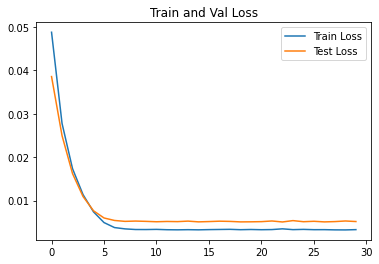

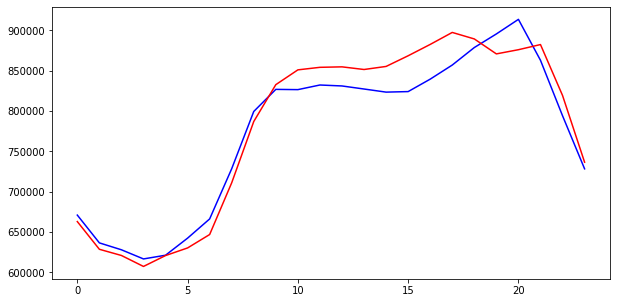

In [32]:
pred, true, mape = main(data_load, data_temp, load_train, '2008-05-24', '2008-05-25')

In [12]:
pred,mape #3 

(array([722263.7 , 699494.2 , 688212.5 , 661911.1 , 670602.  , 708888.44,
        732706.8 , 802112.7 , 859440.75, 886849.94, 880644.  , 886813.56,
        872745.94, 853752.7 , 843862.94, 845186.4 , 851561.1 , 870979.4 ,
        869611.2 , 893827.5 , 894140.94, 871503.  , 813185.94, 761576.44],
       dtype=float32), 2.851598206762611)

In [15]:
pred,mape #4

(array([704107.56, 661619.5 , 637273.  , 643271.3 , 641889.6 , 656313.3 ,
        692688.8 , 748800.3 , 809883.3 , 852097.75, 857566.7 , 851292.25,
        857071.2 , 845730.06, 844105.1 , 855160.44, 864000.  , 879987.75,
        903852.2 , 902907.25, 907159.6 , 878913.44, 817748.1 , 752556.06],
       dtype=float32), 2.6767051622325564)

In [17]:
pred,mape #10

(array([732502.2 , 688775.6 , 674068.5 , 677537.2 , 683217.4 , 701311.4 ,
        745362.1 , 800655.94, 855610.9 , 885263.5 , 894537.1 , 875617.06,
        864463.2 , 850209.3 , 850393.5 , 845593.4 , 860786.  , 872541.5 ,
        892528.7 , 906715.4 , 909509.3 , 872977.06, 826355.9 , 760539.8 ],
       dtype=float32), 2.640535209543669)

In [22]:
pred,mape #11

(array([672128.8 , 644531.4 , 627514.3 , 629528.7 , 622672.4 , 648221.75,
        670975.7 , 725891.75, 797222.3 , 831781.7 , 839651.8 , 830052.56,
        830096.2 , 827295.7 , 823312.4 , 832028.2 , 843744.9 , 854487.5 ,
        859992.75, 885834.3 , 896190.9 , 865297.2 , 795076.75, 728883.25],
       dtype=float32), 4.779272309550459)

In [27]:
pred,mape #17

(array([731037.75, 703420.  , 691252.9 , 699848.3 , 688017.7 , 713063.44,
        750687.56, 814313.75, 861972.3 , 880040.06, 883372.4 , 880565.8 ,
        860676.  , 841352.9 , 850398.94, 844956.6 , 845341.2 , 871053.5 ,
        900561.4 , 902027.3 , 904292.  , 876314.5 , 820509.56, 767322.44],
       dtype=float32), 1.9400613868636798)

In [29]:
pred,mape #18

(array([679339.9 , 644302.3 , 635017.1 , 618284.25, 633306.25, 642114.06,
        684581.  , 739796.75, 798582.2 , 832044.4 , 843925.2 , 847138.3 ,
        831720.2 , 829717.8 , 822484.44, 822123.44, 837395.8 , 850071.75,
        861681.2 , 883060.1 , 904166.9 , 866850.  , 799941.25, 726149.44],
       dtype=float32), 1.9461773967347902)

In [31]:
pred,mape#24

(array([723116.94, 687098.8 , 682145.9 , 668042.3 , 682471.2 , 702044.06,
        739005.2 , 781378.1 , 845422.6 , 875976.  , 884584.8 , 867731.5 ,
        859246.5 , 858134.56, 845543.94, 845181.  , 861732.8 , 875680.3 ,
        884636.7 , 895261.56, 904453.56, 870653.5 , 814099.2 , 747552.75],
       dtype=float32), 2.138582382829222)

In [33]:
pred,mape#25

(array([671102.1 , 636669.7 , 628108.6 , 616772.3 , 621369.2 , 642547.3 ,
        666347.  , 728599.  , 799555.25, 826938.56, 826626.4 , 832358.4 ,
        831177.9 , 827389.2 , 823539.  , 824196.3 , 839621.75, 857105.06,
        878802.06, 895644.4 , 913734.  , 863006.8 , 794251.4 , 728446.75],
       dtype=float32), 2.452260297295727)

In [34]:
ass = np.array([3, 722263.7 , 699494.2 , 688212.5 , 661911.1 , 670602.  , 708888.44,
        732706.8 , 802112.7 , 859440.75, 886849.94, 880644.  , 886813.56,
        872745.94, 853752.7 , 843862.94, 845186.4 , 851561.1 , 870979.4 ,
        869611.2 , 893827.5 , 894140.94, 871503.  , 813185.94, 761576.44,
         4, 704107.56, 661619.5 , 637273.  , 643271.3 , 641889.6 , 656313.3 ,
        692688.8 , 748800.3 , 809883.3 , 852097.75, 857566.7 , 851292.25,
        857071.2 , 845730.06, 844105.1 , 855160.44, 864000.  , 879987.75,
        903852.2 , 902907.25, 907159.6 , 878913.44, 817748.1 , 752556.06,
          10, 732502.2 , 688775.6 , 674068.5 , 677537.2 , 683217.4 , 701311.4 ,
        745362.1 , 800655.94, 855610.9 , 885263.5 , 894537.1 , 875617.06,
        864463.2 , 850209.3 , 850393.5 , 845593.4 , 860786.  , 872541.5 ,
        892528.7 , 906715.4 , 909509.3 , 872977.06, 826355.9 , 760539.8 ,
          11,  672128.8 , 644531.4 , 627514.3 , 629528.7 , 622672.4 , 648221.75,
        670975.7 , 725891.75, 797222.3 , 831781.7 , 839651.8 , 830052.56,
        830096.2 , 827295.7 , 823312.4 , 832028.2 , 843744.9 , 854487.5 ,
        859992.75, 885834.3 , 896190.9 , 865297.2 , 795076.75, 728883.25,
            17, 731037.75, 703420.  , 691252.9 , 699848.3 , 688017.7 , 713063.44,
        750687.56, 814313.75, 861972.3 , 880040.06, 883372.4 , 880565.8 ,
        860676.  , 841352.9 , 850398.94, 844956.6 , 845341.2 , 871053.5 ,
        900561.4 , 902027.3 , 904292.  , 876314.5 , 820509.56, 767322.44,
               18, 679339.9 , 644302.3 , 635017.1 , 618284.25, 633306.25, 642114.06,
        684581.  , 739796.75, 798582.2 , 832044.4 , 843925.2 , 847138.3 ,
        831720.2 , 829717.8 , 822484.44, 822123.44, 837395.8 , 850071.75,
        861681.2 , 883060.1 , 904166.9 , 866850.  , 799941.25, 726149.44,
             24,723116.94, 687098.8 , 682145.9 , 668042.3 , 682471.2 , 702044.06,
        739005.2 , 781378.1 , 845422.6 , 875976.  , 884584.8 , 867731.5 ,
        859246.5 , 858134.56, 845543.94, 845181.  , 861732.8 , 875680.3 ,
        884636.7 , 895261.56, 904453.56, 870653.5 , 814099.2 , 747552.75,
              25,671102.1 , 636669.7 , 628108.6 , 616772.3 , 621369.2 , 642547.3 ,
        666347.  , 728599.  , 799555.25, 826938.56, 826626.4 , 832358.4 ,
        831177.9 , 827389.2 , 823539.  , 824196.3 , 839621.75, 857105.06,
        878802.06, 895644.4 , 913734.  , 863006.8 , 794251.4 , 728446.75 ])

In [36]:
pd.DataFrame(ass.reshape(-1,25)).to_csv('pred_weekend.csv')